# Highly accurate boundaries segmentation using BASNet

**Description:** Boundaries aware segmentation model trained on the DUTS dataset.

## Introduction

Deep semantic segmentation algorithms have improved a lot recently, but still fails to correctly
predict pixels around object boundaries. In this example we implement
**Boundary-Aware Segmentation Network (BASNet)**, using two stage predict and refine
architecture, and a hybrid loss it can predict highly accurate boundaries and fine structures
for image segmentation.

### References:

- [Boundary-Aware Segmentation Network for Mobile and Web Applications](https://arxiv.org/abs/2101.04704)
- [BASNet Keras Implementation](https://github.com/hamidriasat/BASNet/tree/basnet_keras)
- [Learning to Detect Salient Objects with Image-level Supervision](https://openaccess.thecvf.com/content_cvpr_2017/html/Wang_Learning_to_Detect_CVPR_2017_paper.html)

## Download the Data

We will use the [DUTS-TE](http://saliencydetection.net/duts/) dataset for training. It has 5,019
images but we will use 140 for training and validation to save notebook running time. DUTS is
relatively large salient object segmentation dataset. which contain diversified textures and
structures common to real-world images in both foreground and background.

In [3]:
#!wget http://saliencydetection.net/duts/download/DUTS-TE.zip
#!unzip -q DUTS-TE.zip

In [4]:
#!pip3 install keras-cv
#!pip3 install keras-core

In [5]:
import os
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import keras_cv
import tensorflow as tf
from tensorflow import keras
from keras import layers, backend

Using TensorFlow backend


/Users/harsha/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define Hyperparameters

In [6]:
IMAGE_SIZE = 288
BATCH_SIZE = 4
OUT_CLASSES = 1
TRAIN_SPLIT_RATIO = 0.90
DATA_DIR = "./DUTS-TE/"

## Create TensorFlow Dataset

We will use `load_paths()` to load and split 140 paths into train and validation set, and
`load_dataset()` to convert paths into `tf.data.Dataset` object.

In [7]:

def load_paths(path, split_ratio):
    images = sorted(glob(os.path.join(path, "DUTS-TE-Image/*")))[:140]
    masks = sorted(glob(os.path.join(path, "DUTS-TE-Mask/*")))[:140]
    len_ = int(len(images) * split_ratio)
    return (images[:len_], masks[:len_]), (images[len_:], masks[len_:])


def read_image(path, size, mode):
    x = keras.utils.load_img(path, target_size=size, color_mode=mode)
    x = keras.utils.img_to_array(x)
    x = (x / 255.0).astype(np.float32)
    return x


def preprocess(x_batch, y_batch, img_size, out_classes):
    def f(_x, _y):
        _x, _y = _x.decode(), _y.decode()
        _x = read_image(_x, (img_size, img_size), mode="rgb")  # image
        _y = read_image(_y, (img_size, img_size), mode="grayscale")  # mask
        return _x, _y

    images, masks = tf.numpy_function(f, [x_batch, y_batch], [tf.float32, tf.float32])
    images.set_shape([img_size, img_size, 3])
    masks.set_shape([img_size, img_size, out_classes])
    return images, masks


def load_dataset(image_paths, mask_paths, img_size, out_classes, batch, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    if shuffle:
        dataset = dataset.cache().shuffle(buffer_size=1000)
    dataset = dataset.map(
        lambda x, y: preprocess(x, y, img_size, out_classes),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


train_paths, val_paths = load_paths(DATA_DIR, TRAIN_SPLIT_RATIO)

train_dataset = load_dataset(
    train_paths[0], train_paths[1], IMAGE_SIZE, OUT_CLASSES, BATCH_SIZE, shuffle=True
)
val_dataset = load_dataset(
    val_paths[0], val_paths[1], IMAGE_SIZE, OUT_CLASSES, BATCH_SIZE, shuffle=False
)

print(f"Train Dataset: {train_dataset}")
print(f"Validation Dataset: {val_dataset}")

Train Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 288, 288, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 288, 288, 1), dtype=tf.float32, name=None))>
Validation Dataset: <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 288, 288, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 288, 288, 1), dtype=tf.float32, name=None))>


## Visualize Data

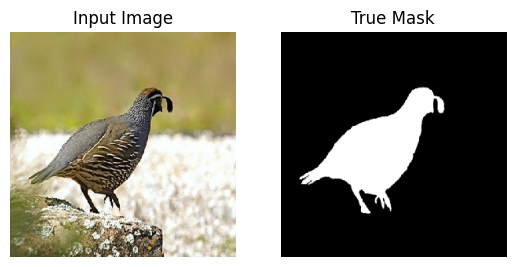

In [8]:

def display(display_list):
    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(keras.utils.array_to_img(display_list[i]), cmap="gray")
        plt.axis("off")
    plt.show()


for image, mask in val_dataset.take(1):
    display([image[0], mask[0]])

## Analyze Mask

Lets print unique values of above displayed mask. You can see despite belonging to one class, it's
intensity is changing between low(0) to high(255). This variation in intensity makes it hard for
network to generate good segmentation map for **salient or camouflaged object segmentation**.
Because of its Residual Refined Module (RMs), BASNet is good in generating highly accurate
boundaries and fine structures.

In [9]:
print(f"Unique values count: {len(np.unique((mask[0] * 255)))}")
print("Unique values:")
print(np.unique((mask[0] * 255)).astype(int))

Unique values count: 245
Unique values:
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  61  62  63  65  66  67  68  69  70  71  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 108 109 110 111 112
 113 114 115 116 117 118 119 120 122 123 124 125 128 129 130 131 132 133
 134 135 136 137 138 139 140 141 142 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 24

## Building the BASNet Model

BASNet comprises of a predict-refine architecture and a hybrid loss. The predict-refine
architecture consists of a densely supervised encoder-decoder network and a residual refinement
module, which are respectively used to predict and refine a segmentation probability map.

![](https://i.imgur.com/8jaZ2qs.png)

In [10]:

def basic_block(x_input, filters, stride=1, down_sample=None, activation=None):
    """Creates a residual(identity) block with two 3*3 convolutions."""
    residual = x_input

    x = layers.Conv2D(filters, (3, 3), strides=stride, padding="same", use_bias=False)(
        x_input
    )
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, (3, 3), strides=(1, 1), padding="same", use_bias=False)(
        x
    )
    x = layers.BatchNormalization()(x)

    if down_sample is not None:
        residual = down_sample

    x = layers.Add()([x, residual])

    if activation is not None:
        x = layers.Activation(activation)(x)

    return x


def convolution_block(x_input, filters, dilation=1):
    """Apply convolution + batch normalization + relu layer."""
    x = layers.Conv2D(filters, (3, 3), padding="same", dilation_rate=dilation)(x_input)
    x = layers.BatchNormalization()(x)
    return layers.Activation("relu")(x)


def segmentation_head(x_input, out_classes, final_size):
    """Map each decoder stage output to model output classes."""
    x = layers.Conv2D(out_classes, kernel_size=(3, 3), padding="same")(x_input)

    if final_size is not None:
        x = layers.Resizing(final_size[0], final_size[1])(x)

    return x


def get_resnet_block(_resnet, block_num):
    """Extract and return ResNet-34 block."""
    resnet_layers = [3, 4, 6, 3]  # ResNet-34 layer sizes at different block.
    return keras.models.Model(
        inputs=_resnet.get_layer(f"v2_stack_{block_num}_block1_1_conv").input,
        outputs=_resnet.get_layer(
            f"v2_stack_{block_num}_block{resnet_layers[block_num]}_add"
        ).output,
        name=f"resnet34_block{block_num + 1}",
    )


## Prediction Module

Prediction module is a heavy encoder decoder structure like U-Net. The encoder includes an input
convolutional layer and six stages. First four are adopted from ResNet-34 and rest are basic
res-blocks. Since first convolution and pooling layer of ResNet-34 is skipped so we will use
`get_resnet_block()` to extract first four blocks. Both bridge and decoder uses three
convolutional layers with side outputs. The module produces seven segmentation probability
maps during training, with the last one considered the final output.

In [11]:

def basnet_predict(input_shape, out_classes):
    """BASNet Prediction Module, it outputs coarse label map."""
    filters = 64
    num_stages = 6

    x_input = layers.Input(input_shape)

    # -------------Encoder--------------
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(x_input)

    resnet = keras_cv.models.ResNet34Backbone(
        include_rescaling=False,
    )

    encoder_blocks = []
    for i in range(num_stages):
        if i < 4:  # First four stages are adopted from ResNet-34 blocks.
            x = get_resnet_block(resnet, i)(x)
            encoder_blocks.append(x)
            x = layers.Activation("relu")(x)
        else:  # Last 2 stages consist of three basic resnet blocks.
            x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
            x = basic_block(x, filters=filters * 8, activation="relu")
            x = basic_block(x, filters=filters * 8, activation="relu")
            x = basic_block(x, filters=filters * 8, activation="relu")
            encoder_blocks.append(x)

    # -------------Bridge-------------
    x = convolution_block(x, filters=filters * 8, dilation=2)
    x = convolution_block(x, filters=filters * 8, dilation=2)
    x = convolution_block(x, filters=filters * 8, dilation=2)
    encoder_blocks.append(x)

    # -------------Decoder-------------
    decoder_blocks = []
    for i in reversed(range(num_stages)):
        if i != (num_stages - 1):  # Except first, scale other decoder stages.
            shape = keras.backend.int_shape(x)
            x = layers.Resizing(shape[1] * 2, shape[2] * 2)(x)

        x = layers.concatenate([encoder_blocks[i], x], axis=-1)
        x = convolution_block(x, filters=filters * 8)
        x = convolution_block(x, filters=filters * 8)
        x = convolution_block(x, filters=filters * 8)
        decoder_blocks.append(x)

    decoder_blocks.reverse()  # Change order from last to first decoder stage.
    decoder_blocks.append(encoder_blocks[-1])  # Copy bridge to decoder.

    # -------------Side Outputs--------------
    decoder_blocks = [
        segmentation_head(decoder_block, out_classes, input_shape[:2])
        for decoder_block in decoder_blocks
    ]

    return keras.models.Model(inputs=[x_input], outputs=decoder_blocks)


## Residual Refinement Module

Refinement Modules (RMs), designed as a residual block aim to refines the coarse(blurry and noisy
boundaries) segmentation maps generated by prediction module. Similar to prediction module it's
also an encode decoder structure but with light weight 4 stages, each containing one
`convolutional block()` init. At the end it adds both coarse and residual output to generate
refined output.

In [12]:

def basnet_rrm(base_model, out_classes):
    """BASNet Residual Refinement Module(RRM) module, output fine label map."""
    num_stages = 4
    filters = 64

    x_input = base_model.output[0]

    # -------------Encoder--------------
    x = layers.Conv2D(filters, kernel_size=(3, 3), padding="same")(x_input)

    encoder_blocks = []
    for _ in range(num_stages):
        x = convolution_block(x, filters=filters)
        encoder_blocks.append(x)
        x = layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)

    # -------------Bridge--------------
    x = convolution_block(x, filters=filters)

    # -------------Decoder--------------
    for i in reversed(range(num_stages)):
        shape = keras.backend.int_shape(x)
        x = layers.Resizing(shape[1] * 2, shape[2] * 2)(x)
        x = layers.concatenate([encoder_blocks[i], x], axis=-1)
        x = convolution_block(x, filters=filters)

    x = segmentation_head(x, out_classes, None)  # Segmentation head.

    # ------------- refined = coarse + residual
    x = layers.Add()([x_input, x])  # Add prediction + refinement output

    return keras.models.Model(inputs=[base_model.input], outputs=[x])


## Combine Predict and Refinement Module

In [13]:

def basnet(input_shape, out_classes):
    """BASNet, it's a combination of two modules
    Prediction Module and Residual Refinement Module(RRM)."""

    # Prediction model.
    predict_model = basnet_predict(input_shape, out_classes)
    # Refinement model.
    refine_model = basnet_rrm(predict_model, out_classes)

    output = [refine_model.output]  # Combine outputs.
    output.extend(predict_model.output)

    output = [layers.Activation("sigmoid")(_) for _ in output]  # Activations.

    return keras.models.Model(inputs=[predict_model.input], outputs=output)


## Hybrid Loss

Another important feature of BASNet is its hybrid loss function, which is a combination of
binary cross entropy, structural similarity and intersection-over-union losses, which guide
the network to learn three-level (i.e., pixel, patch and map level) hierarchy representations.

In [14]:

class BasnetLoss(keras.losses.Loss):
    """BASNet hybrid loss."""

    def __init__(self, **kwargs):
        super().__init__(name="basnet_loss", **kwargs)
        self.smooth = 1.0e-9

        # Binary Cross Entropy loss.
        self.cross_entropy_loss = keras.losses.BinaryCrossentropy()
        # Structural Similarity Index value.
        self.ssim_value = tf.image.ssim
        #  Jaccard / IoU loss.
        self.iou_value = self.calculate_iou

    def calculate_iou(
        self,
        y_true,
        y_pred,
    ):
        """Calculate intersection over union (IoU) between images."""
        intersection = backend.sum(backend.abs(y_true * y_pred), axis=[1, 2, 3])
        union = backend.sum(y_true, [1, 2, 3]) + backend.sum(y_pred, [1, 2, 3])
        union = union - intersection
        return backend.mean(
            (intersection + self.smooth) / (union + self.smooth), axis=0
        )

    def call(self, y_true, y_pred):
        cross_entropy_loss = self.cross_entropy_loss(y_true, y_pred)

        ssim_value = self.ssim_value(y_true, y_pred, max_val=1)
        ssim_loss = backend.mean(1 - ssim_value + self.smooth, axis=0)

        iou_value = self.iou_value(y_true, y_pred)
        iou_loss = 1 - iou_value

        # Add all three losses.
        return cross_entropy_loss + ssim_loss + iou_loss


basnet_model = basnet(
    input_shape=[IMAGE_SIZE, IMAGE_SIZE, 3], out_classes=OUT_CLASSES
)  # Create model.
basnet_model.summary()  # Show model summary.

optimizer = keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-8)
# Compile model.
basnet_model.compile(
    loss=BasnetLoss(),
    optimizer=optimizer,
    metrics=[keras.metrics.MeanAbsoluteError(name="mae")],
)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 288, 288, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 288, 288, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 resnet34_block1 (Functiona  (None, None, None, 64)       222720    ['conv2d[0][0]']              
 l)                                                                                               
                                                                                                  
 activation (Activation)     (None, 288, 288, 64)         0         ['resnet34_block1[0][0]'

### Train the Model

In [15]:
basnet_model.fit(train_dataset, validation_data=val_dataset, epochs=1)

32/32 [==============================] - 1638s 51s/step - loss: 16.1576 - activation_46_loss: 2.0476 - activation_47_loss: 2.0722 - activation_48_loss: 2.0558 - activation_49_loss: 2.1324 - activation_50_loss: 2.0117 - activation_51_loss: 1.9645 - activation_52_loss: 1.8853 - activation_53_loss: 1.9882 - activation_46_mae: 0.2534 - activation_47_mae: 0.2689 - activation_48_mae: 0.2752 - activation_49_mae: 0.3084 - activation_50_mae: 0.2575 - activation_51_mae: 0.2529 - activation_52_mae: 0.2294 - activation_53_mae: 0.2445 - val_loss: 18.3219 - val_activation_46_loss: 2.3350 - val_activation_47_loss: 2.3427 - val_activation_48_loss: 2.3154 - val_activation_49_loss: 2.3181 - val_activation_50_loss: 2.3434 - val_activation_51_loss: 2.2827 - val_activation_52_loss: 2.1929 - val_activation_53_loss: 2.1917 - val_activation_46_mae: 0.2456 - val_activation_47_mae: 0.2389 - val_activation_48_mae: 0.2726 - val_activation_49_mae: 0.2739 - val_activation_50_mae: 0.2605 - val_activation_51_mae: 0.2

### Visualize Predictions

In paper BASNet was trained on DUTS-TR dataset, which has 10553 images. Model was trained for 400k
iterations with a batch size of eight and without a validation dataset. After training model was
evaluated on DUTS-TE dataset and achieved a mean absolute error of `0.042`.

Since BASNet is a deep model and cannot be trained in a short amount of time which is a
requirement for keras example notebook, so we will load pretrained weights from [here](https://github.com/hamidriasat/BASNet/tree/basnet_keras)
to show model prediction. Due to computer power limitation this model was trained for 120k
iterations but it still demonstrates its capabilities. For further details about
trainings parameters please check given link.

In [16]:
!!gdown 1OWKouuAQ7XpXZbWA3mmxDPrFGW71Axrg

['zsh:1: command not found: gdown']

In [20]:

def normalize_output(prediction):
    max_value = np.max(prediction)
    min_value = np.min(prediction)
    return (prediction - min_value) / (max_value - min_value)


# Load weights.
basnet_model.load_weights("./basnet_weights.h5")

### Make Predictions

1/1 [==============================] - 12s 12s/step


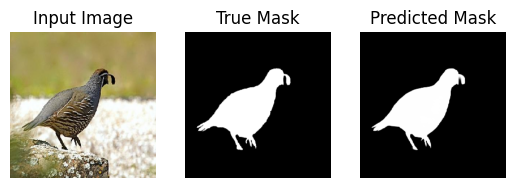

1/1 [==============================] - 12s 12s/step


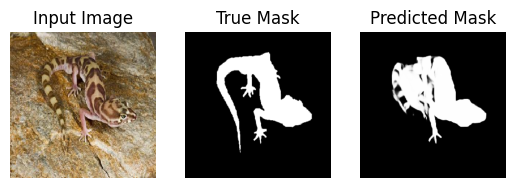

1/1 [==============================] - 13s 13s/step


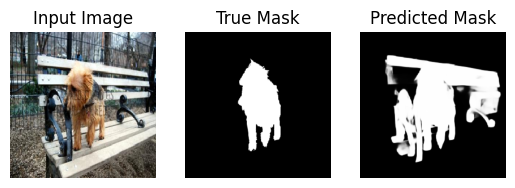

1/1 [==============================] - 6s 6s/step


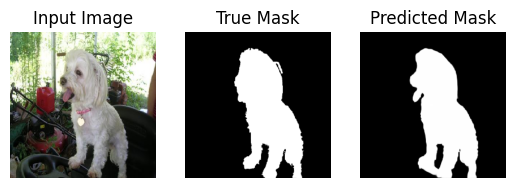

In [23]:
for image, mask in val_dataset.take(5):
    pred_mask = basnet_model.predict(image)
    display([image[0], mask[0], normalize_output(pred_mask[0][0])])